In [1]:
import sys

sys.path.append("..")

!wget https://sergey-filimonov.nyc3.digitaloceanspaces.com/open-parse/sample-docs/lyft_2021-first-20-pages.pdf -O sample-docs/lyft-10k.pdf

--2024-04-07 21:34:30--  https://sergey-filimonov.nyc3.digitaloceanspaces.com/open-parse/sample-docs/lyft_2021-first-20-pages.pdf
Resolving sergey-filimonov.nyc3.digitaloceanspaces.com (sergey-filimonov.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to sergey-filimonov.nyc3.digitaloceanspaces.com (sergey-filimonov.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379188 (370K) [application/pdf]
Saving to: ‘sample-docs/lyft-10k.pdf’

sample-docs/lyft-10 100%[===================>] 370.30K  1.38MB/s    in 0.3s    

2024-04-07 21:34:31 (1.38 MB/s) - ‘sample-docs/lyft-10k.pdf’ saved [379188/379188]



## Motivation

Chunking documents is fundamentally about grouping similar semantic nodes together. Perhaps the most powerful way to do this is to use embeddings.

### Considerations
1. We want to group similar elements together
2. If your chunking results in Nodes that are too small, you will miss out on valuable context that might be needed to understand the document
3. If your chunking results in Nodes that are too large, you will lose the ability to differentiate between different parts of the document

With that said, we have a bias towards chunking that results in larger nodes - models now have very large context windows. If you're building simpler RAG systems, you might want to chunk into smaller nodes to make the retrieval process more efficient.

A more thorough discussion can be found [here](https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5).

In [4]:
from openparse import Node
from openparse import processing
import numpy as np

# let's define some simple utility functions

OPEN_AI_KEY = "sk-..."

embedding_client = processing.OpenAIEmbeddings(
    api_key=OPEN_AI_KEY,
    model="text-embedding-3-large",
)


def cosine_similarity(
    a: np.ndarray | list[float], b: np.ndarray | list[float]
) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def get_node_similarities(nodes: list[Node]):
    # get the similarity of each node with the node that precedes it
    embeddings = embedding_client.embed_many([node.text for node in nodes])
    similarities = []
    for i in range(1, len(embeddings)):
        similarities.append(cosine_similarity(embeddings[i - 1], embeddings[i]))

    similarities = [round(sim, 2) for sim in similarities]
    return [0] + similarities

## Visualizing Raw Node Similarity 

Let's try applying some basic preprocessing to a sample document and visualize the similarity between the nodes. 

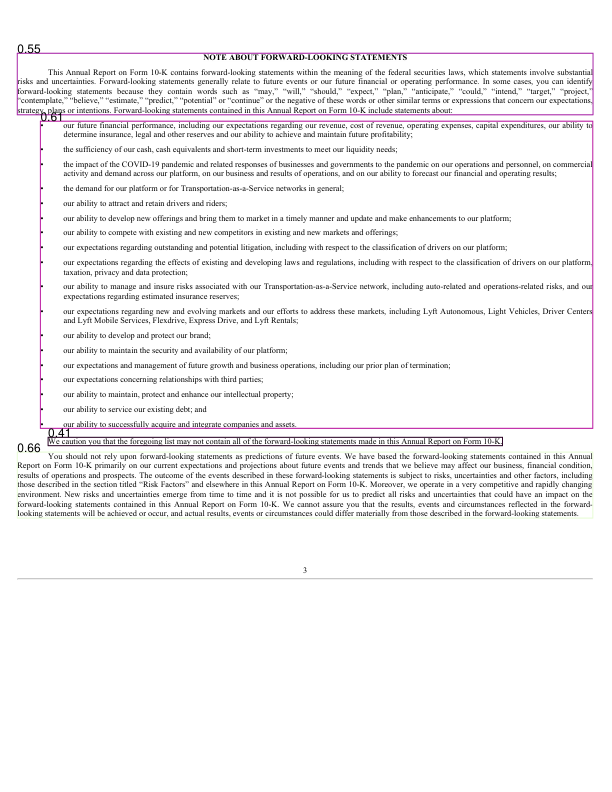

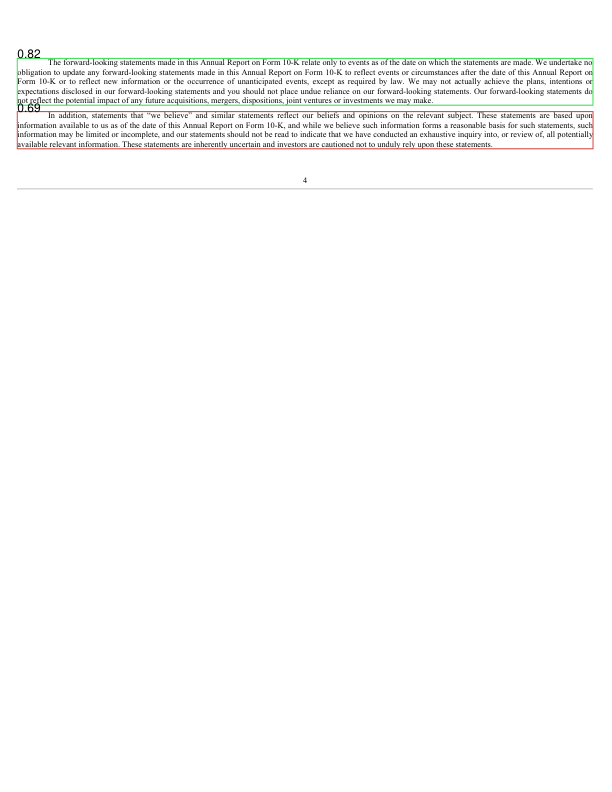

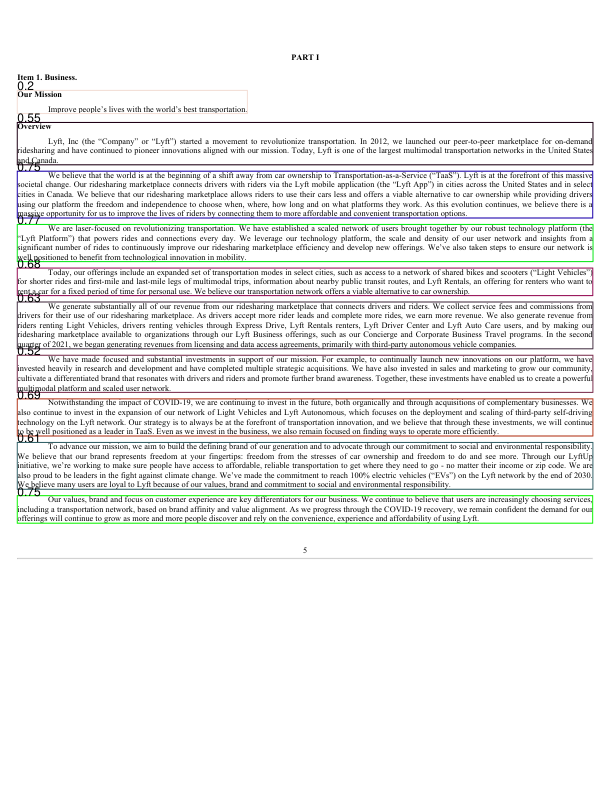

In [5]:
import openparse
from openparse import processing, Pdf


class MinimalIngestionPipeline(processing.IngestionPipeline):
    def __init__(self):
        self.transformations = [
            # combines bullets and weird formatting
            processing.CombineNodesSpatially(
                x_error_margin=10,
                y_error_margin=2,
                criteria="both_small",
            ),
            processing.CombineHeadingsWithClosestText(),
            processing.CombineBullets(),
            processing.RemoveMetadataElements(),
            processing.RemoveNodesBelowNTokens(min_tokens=10),
        ]


# perform very basic parsing to clean up the document
basic_doc_path = "./sample-docs/lyft-10k.pdf"
doc = Pdf(file=basic_doc_path)
parser = openparse.DocumentParser(
    processing_pipeline=MinimalIngestionPipeline(),
)
parsed_content = parser.parse(basic_doc_path)

# annotate the document with similarity scores
annotations = get_node_similarities(parsed_content.nodes)
doc.display_with_bboxes(
    parsed_content.nodes, annotations=annotations, page_nums=[2, 3, 4]
)

## Now let's try combining these semantically

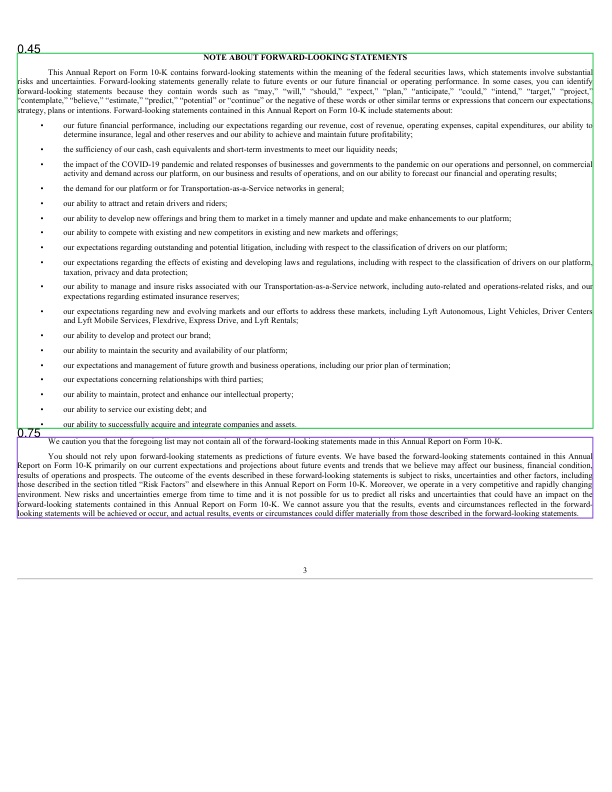

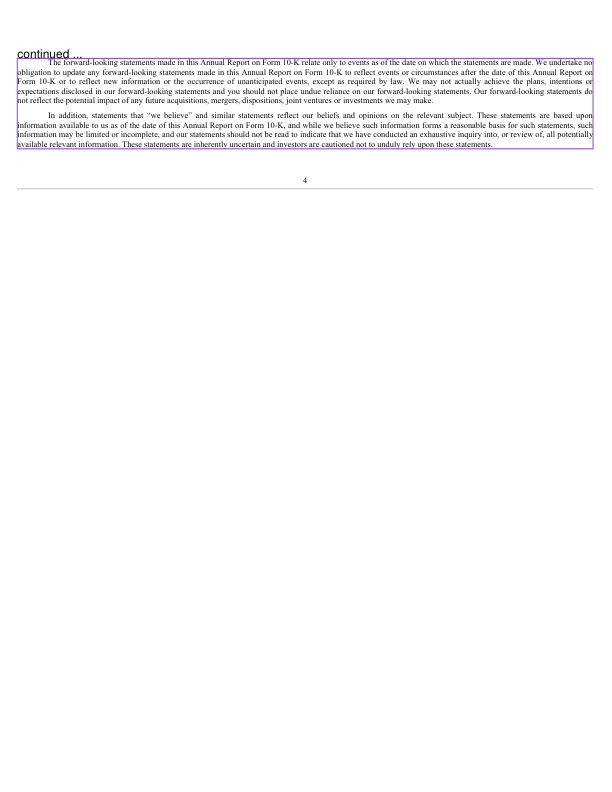

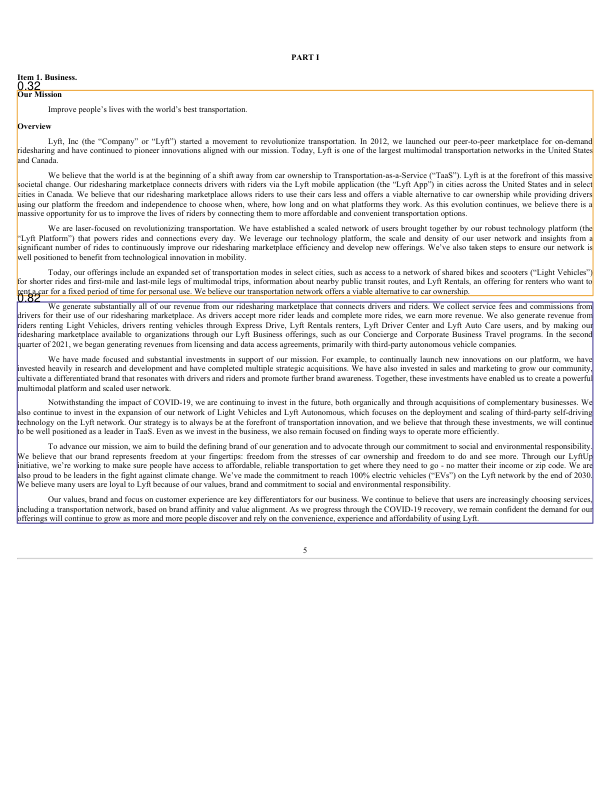

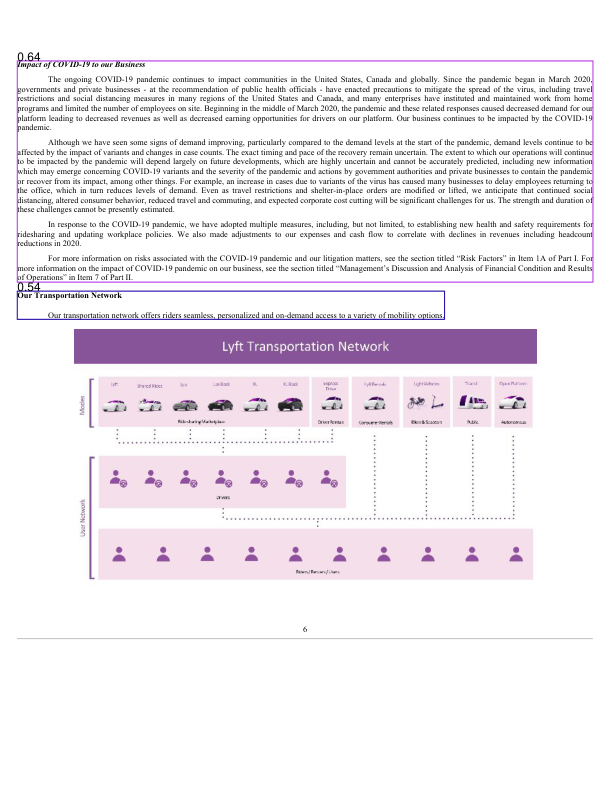

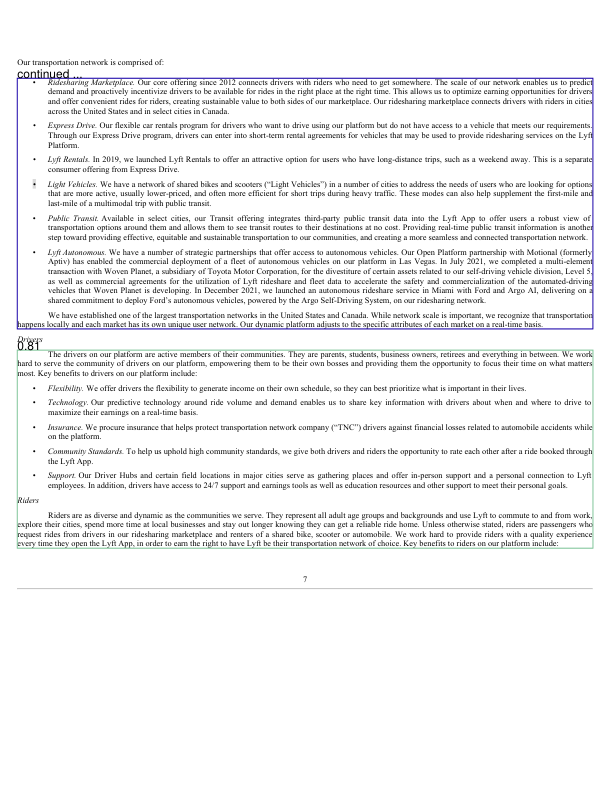

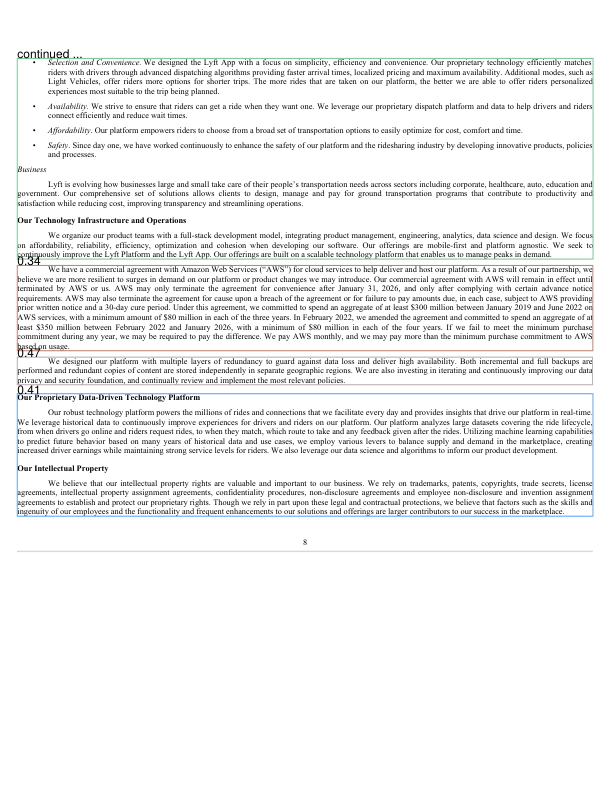

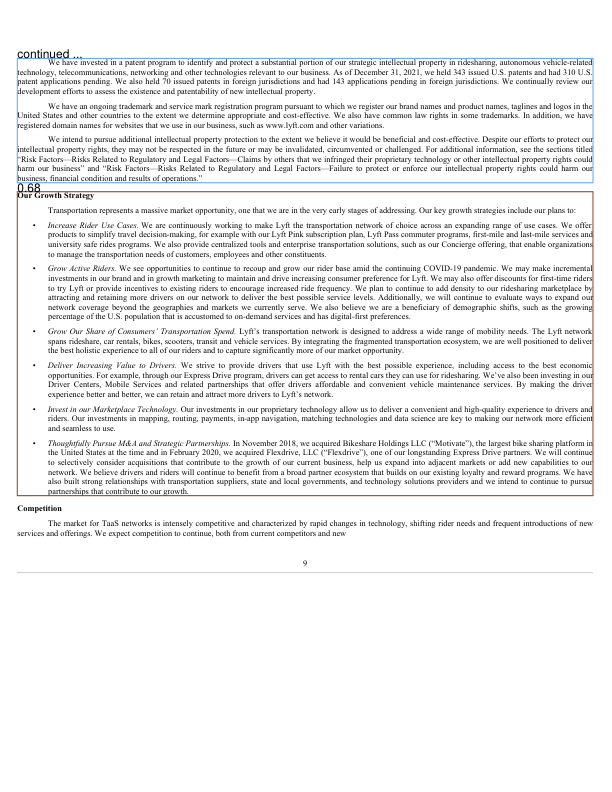

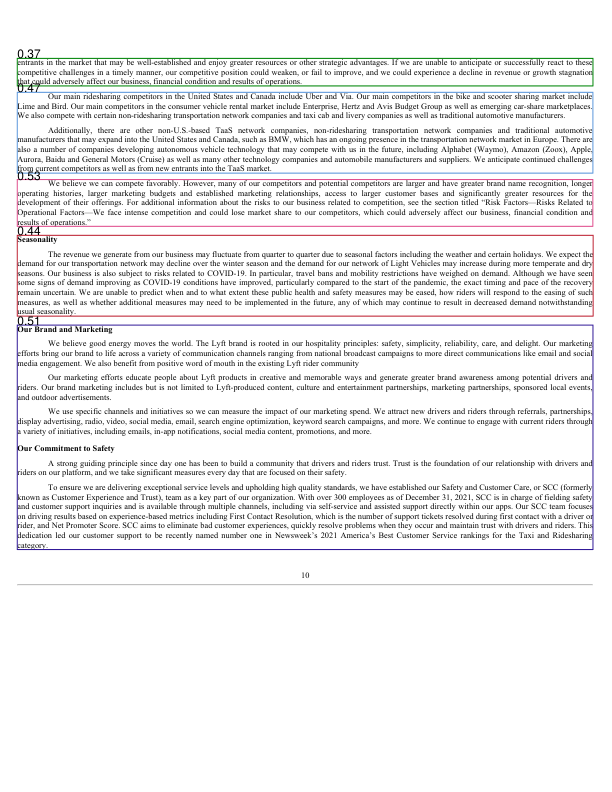

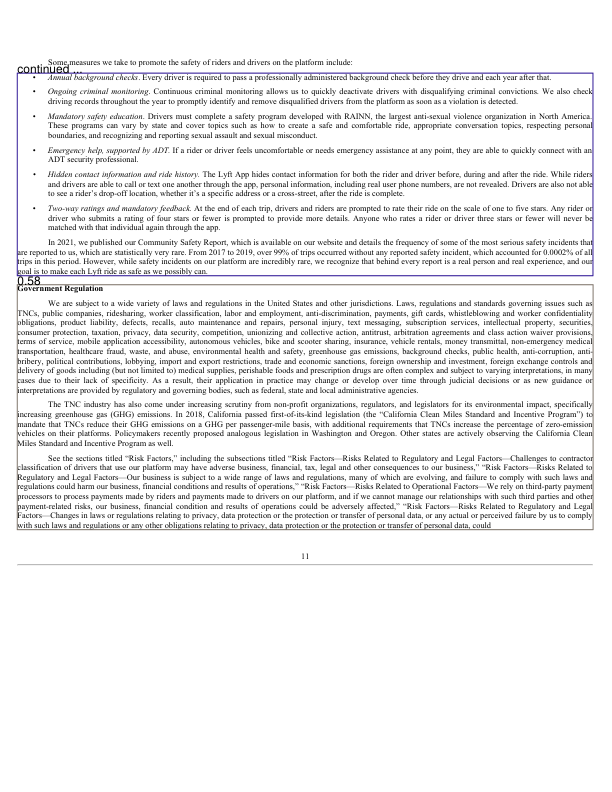

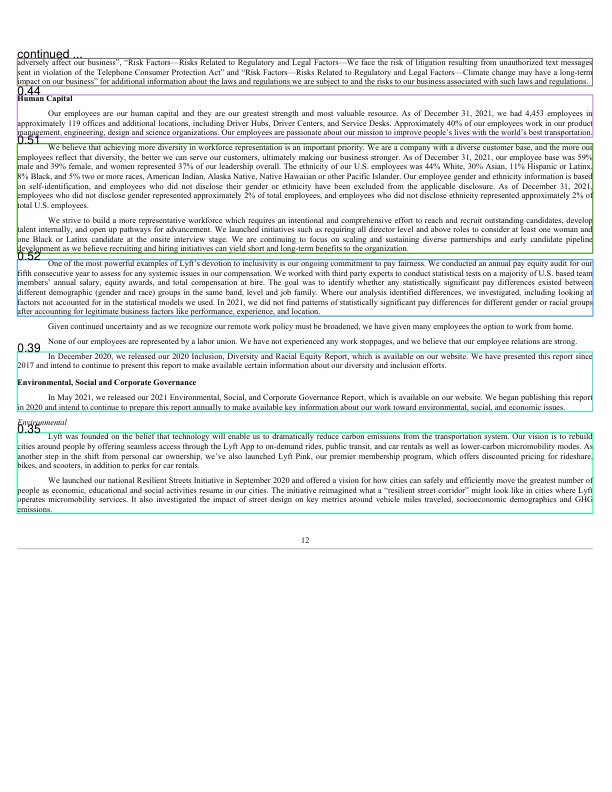

In [6]:
# intialize the semantic pipeline
semantic_pipeline = processing.SemanticIngestionPipeline(
    openai_api_key=OPEN_AI_KEY,
    model="text-embedding-3-large",
    min_tokens=64,
    max_tokens=1024,
)
parser = openparse.DocumentParser(
    processing_pipeline=semantic_pipeline,
)
parsed_content = parser.parse(basic_doc_path)

# annotate the document with similarity scores
annotations = get_node_similarities(parsed_content.nodes)
doc.display_with_bboxes(
    parsed_content.nodes,
    annotations=annotations,
    page_nums=list(range(2, 12)),
)